In [165]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from math import radians, sin, cos, atan2, sqrt
from pprint import pprint

In [14]:
df = pd.read_csv('1854 WCR 2023.csv',header=1)

In [16]:
s = set()
total_loc = set()
for t in df[['Where From', 'Where Bound']].iterrows():
    wf = t[1]['Where From']
    wb = t[1]['Where Bound']
    s.add((wf, wb))
    total_loc.add(wf)
    total_loc.add(wb)
print(len(s))
print(len(total_loc))

425
152


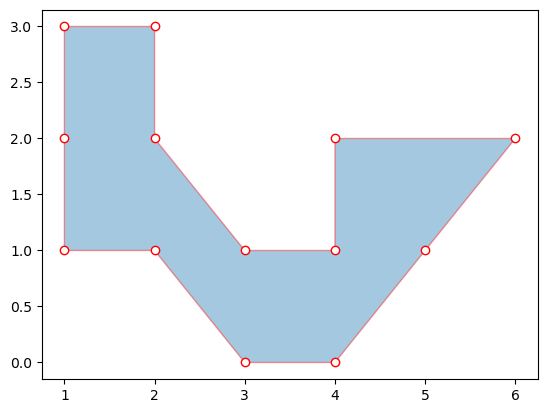

In [12]:
from matplotlib.patches import Polygon

node_coods = [(1.00,1.00), (1.00,2.00), (1.00,3.00), (2.00,3.00), (2.00,2.00), (3.00,1.00), (4.00,1.00), (4.00,2.00), (6.00,2.00), (5.00,1.00), (4.00,0.00), (3.00,0.00), (2.00,1.00)]
x = [t[0] for t in node_coods]
y = [t[1] for t in node_coods]
polygon = Polygon(node_coods, edgecolor='r', alpha=0.4)
# patches = [polygon]
# p = PatchCollection(patches,  alpha=0.4)

fig, ax = plt.subplots()
ax.add_patch(polygon)
ax.scatter(x, y, c='w',edgecolor='r')

In [20]:
with open('water_paths.json') as wp_geojson:
    gj = json.loads(wp_geojson.read())
    

In [209]:
def feature_filter(gj, gid_list=None, exclude=True):
    filtered = []
    for f in gj['features']:
        if not gid_list:
            filtered.append(f)
            continue
            
        if exclude: 
            if f['properties']['gid'] in gid_list: continue
            else:
                filtered.append(f)
        else:
            if f['properties']['gid'] in gid_list: 
                filtered.append(f)
            else:
                continue
    return filtered
    
features = feature_filter(gj, [7], exclude=False)
pprint(features)

[{'geometry': {'coordinates': [[-83.90947399999999, 45.81850200000008],
                               [-83.77403196399996, 45.81698262500004],
                               [-83.59461999999996, 45.81497000000007]],
               'type': 'LineString'},
  'id': 7,
  'properties': {'OBJECTID': 7,
                 'Shape__Length': 0.31487381018435934,
                 'amile': 242,
                 'anode': 61230,
                 'bmile': 228.2,
                 'bnode': 226020,
                 'chart_id': '14860',
                 'ctrl_depth': 60,
                 'date_mod': '01201997',
                 'featurid': 612633,
                 'fips': '26',
                 'fips2': '99',
                 'func_class': 'D',
                 'geo_class': 'G',
                 'gid': 7,
                 'heading': 'E',
                 'id': 612633,
                 'length': 15.21,
                 'length1': 15.2,
                 'length_src': 'V',
                 'linkname': 'LAKE H

{(1, 2): Text(-0.242971288732163, 0.04616592154924462, '5'),
 (1, 4): Text(-0.14969048659265366, -0.04046327113924295, '1'),
 (2, 3): Text(-0.27729929064313, -0.07867613712401421, '1'),
 (3, 4): Text(-0.18401848850362068, -0.1653053298125018, '1'),
 (3, 5): Text(-0.20328954189721604, -0.23756674735824454, '2'),
 (4, 5): Text(-0.1267493921348377, -0.21468439500625985, '2')}

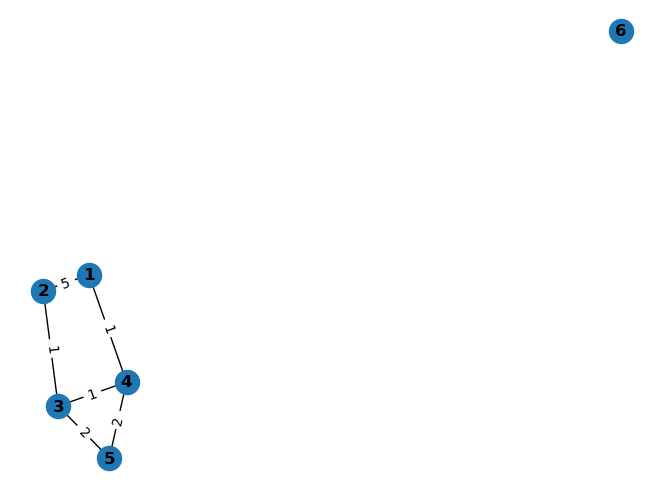

In [105]:
import networkx as nx
G = nx.Graph()
G.add_nodes_from([1,2,3,4,5])
G.add_edges_from([(1,2, {'weight':3}), (2,3, {'weight':1}), (1,4, {'weight':1}), (1,4, {'weight':1}), (4,3, {'weight':1}), (4,5, {'weight':2}), (5,3, {'weight':2})])
G.add_node(6,custom_attr='z')
G[1][2]['weight']=5
G[1][2]['weight']=5
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, font_weight='bold')
el=nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=el)

In [66]:
nx.shortest_path(G, source=1, target=3, weight='weight')

[1, 4, 3]

In [111]:
G.nodes[6]

{'custom_attr': 'z'}

In [183]:
def distance(p1, p2):
    '''returns distance in KM between two points'''
    earth_radius = 6371
    lat1, lat2 = radians(p1[1]), radians(p2[1])
    lon1, lon2 = radians(p1[0]), radians(p2[0])
    
    #https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    base = earth_radius * c
    return base

distance((-83.90947399999999,45.81850200000008),(-83.77403196399996,45.81698262500004))

10.497646606487569

In [210]:
def draw_graph(G):
    pos = nx.planar_layout(G)
    nx.draw(G, pos, with_labels=True, font_weight='bold')
    el=nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=el)

def path_distance(g, path):
    prev = path[0]
    distances = []
    for p in path[1:-1]:
        distances.append(g.edges[(prev,p)]['weight'])
        prev = p
    p = path[-1]
    distances.append(g.edges[(prev,p)]['weight'])
    return sum(distances)

def geojson_to_graph(features):
    G = nx.Graph()
    for feat in features:
        feat_geo = feat['geometry']['coordinates']
        anode = str(feat['properties']['anode'])
        bnode = str(feat['properties']['bnode'])
        #length = feat['properties']['length']
        id = feat['properties']['OBJECTID']
        id_postfix = 1
        G.add_node(anode, coordinates=tuple(feat_geo[0]))
        G.add_node(bnode, coordinates=tuple(feat_geo[-1]))

        prev = anode
        prev_coord = feat_geo[0]
        for point in feat_geo[1:-1]:
            name = f"{id}_{id_postfix}"
            id_postfix += 1
            G.add_node(name, coordinates=tuple(point))
            G.add_edge(prev,name, weight=distance(prev_coord, point))
            prev = name
            prev_coord = point
        G.add_edge(prev, bnode, weight=distance(prev_coord, feat_geo[-1]))
    return G

features = feature_filter(gj, exclude=False)
g = geojson_to_graph(features)

In [185]:
g.edges[('61230', '7_1')], 

({'weight': 10.497646606487569},)

In [186]:
g.edges[('226020', '7_1')]

{'weight': 13.906044211540713}

In [163]:
g.nodes['82_1'],g['82_1'],g.nodes['11300']

({'coordinates': (-88.58400999999998, 37.08857000000006)},
 AtlasView({'170': {'weight': 1}, '11300': {'weight': 0}}),
 {'coordinates': (-88.58400999999998, 37.08857000000006)})

In [204]:
for (u, v, wt) in g.edges.data('weight'):
    print(u,v,wt)

65550 697_1 27.275193181056004
60800 697_4 12.057993952821914
697_1 697_2 5.011015806098512
697_2 697_3 11.903326259845173
697_3 697_4 0.3155366949771066


In [207]:
sum([tup[2] for tup in g.edges.data('weight')])

408.36878829357

In [220]:
sp = nx.shortest_path(g,'63100','62290', weight='weight')

In [242]:
def path_to_coordinates(g, path):
    return [g.nodes[node]['coordinates'] for node in path]

def coordinates_to_geojson(coordinates):
    geo_json = {"type": "Feature",
                "properties":{},
                "geometry":{
                    "type":"LineString",
                    "coordinates":[]
                }}
                
    
    for coordinate in coordinates:
        geo_json['geometry']['coordinates'].append(list(coordinate))
    
    return geo_json

def shortest_path_to_geojson(g, start, end):
    if isinstance(start, int): 
        start = str(start)
    if isinstance(end, int):
        end = str(end)
        
    sp = nx.shortest_path(g,start,end, weight='weight')
    return coordinates_to_geojson(path_to_coordinates(g, sp))

def shortest_paths_to_geojson(g, start_end_pairs):
    geo_json = {"type":"FeatureCollection",
                "features":[]
               }
    geo_json['features'] = [shortest_path_to_geojson(g, start, end) for start, end in start_end_pairs]
    return json.dumps(geo_json)
                        
        
with open('path.json', 'w') as pf:
    pf.write(shortest_paths_to_geojson(g, [(63100, 300830), (5050, 65450), (490,62870), (62570,300730), (67050, 64470)]))
#shortest_path_to_geojson(g, 63100, 300830)
#g.nodes['64470']['coordinates']
#path_distance(g,sp)

In [240]:
a = shortest_path_to_geojson(g, 490, 62870)

In [241]:
a

{'type': 'Feature',
 'properties': {},
 'geometry': {'type': 'LineString',
  'coordinates': [[-92.70955999999995, 45.321740000000034],
   [-92.71199999999999, 45.320020000000056],
   [-92.71461999999997, 45.31832000000003],
   [-92.71710999999999, 45.316680000000076],
   [-92.72013999999996, 45.31443000000007],
   [-92.72221999999994, 45.312550000000044],
   [-92.72544999999997, 45.310820000000035],
   [-92.72830999999996, 45.309090000000026],
   [-92.72978999999998, 45.307300000000055],
   [-92.73067999999995, 45.30568000000005],
   [-92.73517999999996, 45.302130000000034],
   [-92.73713999999995, 45.30037000000004],
   [-92.73924999999997, 45.29992000000004],
   [-92.74124999999998, 45.29896000000008],
   [-92.74333999999999, 45.297570000000064],
   [-92.74517999999995, 45.297270000000026],
   [-92.74647999999996, 45.29649000000006],
   [-92.74805999999995, 45.29545000000007],
   [-92.74921999999998, 45.29427000000004],
   [-92.75019999999995, 45.29370000000006],
   [-92.751509999999